In [1]:
%matplotlib inline

In [2]:
from boilerplate import *
import os, sys
import functional_vectorizer
from dio import dataio
from scipy import fftpack, signal, special
from imp import reload
style.use('dark_background')

In [3]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianDropout, GaussianNoise, Reshape
from keras.layers import LSTM
from keras.layers.convolutional import Convolution1D, Convolution2D, AtrousConvolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import regularizers
from sklearn import manifold
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [4]:

# data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_mh_ftfc_9583_566')
# data_t, Y_t = dataio.reload_with_labels('/home/mike/ve/ml/vec_mh_ftfc_9648_087')
# files1 = pd.read_csv('/home/mike/ve/ml/vec_mh_ftfc_9583_566_name.csv')
# files2 = pd.read_csv('/home/mike/ve/ml/vec_mh_ftfc_9648_087_name.csv')

In [4]:
# this is the LF data vectorized with the autoencoder
data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9598_376')
data_t, Y_t = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9607_384')
files1 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9598_376_name.csv')
files2 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9607_384_name.csv')

In [5]:
data_all = np.concatenate([data, data_t], axis=0)
Y_all = np.concatenate([Y, Y_t ], axis=0)
files_all = pd.concat([files1, files2], axis=0)

In [17]:
print(data.shape, Y.shape, files_all.shape, np.mean(Y, axis=0), np.sum(Y))

((127184, 16), (6041, 1), (7949, 2), array([ 0.07432544]), 449)


In [7]:
# files.to_csv('vec_enc_lf256_16_each_label_names.csv')

In [8]:
data = np.load('vec_enc_lf256_16_each.npy')
labels = np.load('vec_enc_lf256_16_each_label.npy')
print(data.shape, labels.shape)

((127184, 16), (7949, 1))


In [9]:
def respool_electrodes(data, nchan=16):
    ndata, ndim = data.shape
    newdata = np.zeros((ndata//nchan, nchan,ndim ))
    for i in range(0, len(data), nchan):
        for j in range(0, nchan):
#             newframe.append(data[j])
            k = i // nchan
            newdata[k][j] = data[i+j]
#         newdata.append(np.array(newframe).ravel())
        
    return np.asarray(newdata).reshape(ndata//nchan, -1)

In [10]:
data2 = respool_electrodes(data)
data2 = data2[:Y.shape[0]]
data2.shape

(6041, 256)

In [11]:
data2[0].shape

(256,)

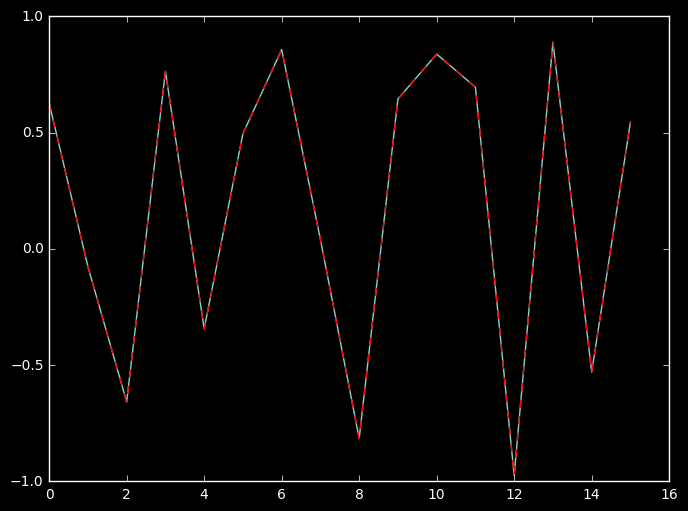

In [12]:
n = 3
plot(data[n])
plot(data2[0, n*16:(n+1)*16], 'r--')

In [14]:
# INTENSIVE
tsne1 = manifold.TSNE()
txdata = tsne1.fit_transform(data2)

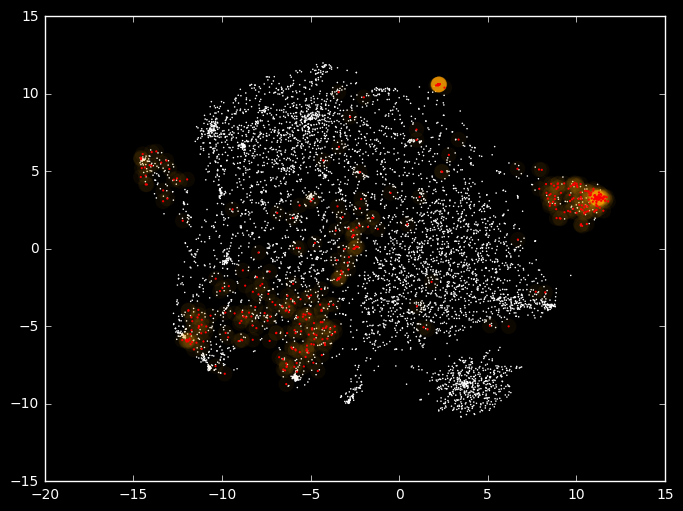

In [43]:
cut = 6041-449
plt.scatter(txdata[:cut,0], txdata[:cut,1], c='w', s=5, marker='.',   edgecolors='none')
plt.scatter(txdata[cut:,0], txdata[cut:,1], c='orange', s=500, marker='.', edgecolors='none', alpha=0.05)
plt.scatter(txdata[cut:,0], txdata[cut:,1], c='r', s=10, marker='.', edgecolors='none')

In [44]:
np.save('vec_tsne_ae256_16', txdata)

In [14]:
def deepclass0(ds_shape):
    n_input_len=ds_shape[1]
    model = Sequential()
    model.add(Convolution1D(nb_filter=64, filter_length=8, input_dim=1, 
                            input_length=n_input_len, border_mode='same', activation='relu'))
    model.add(MaxPooling1D(pool_length=2))
    model.add(LSTM(100))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

In [36]:
def deepclass1(ds_shape, compression_factor=8, input_noise=0.2, dropout_p=0.2, activ='tanh', final_activ='sigmoid'):
# compression_factor=20
    print('DS shape: {}'.format(ds_shape))
    in_dims = ds_shape[1]
    encoding_dim = int(in_dims//compression_factor)
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, ds_shape, encoding_dim))
    
    ndim_conv = 64
    # this is our input placeholder
    model = Sequential()
#     model.add(Input(shape=(in_dims,)))
    model.add(GaussianNoise(input_noise, input_shape=(in_dims,)))
#     model.add(Reshape((in_dims,1)))
#     model.add(AtrousConvolution1D(nb_filter=ndim_conv, filter_length=8, border_mode='same', input_dim=1, activation='relu'))
#     model.add(MaxPooling1D(pool_length=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_p)) 
    print(model.layers[-1].output_shape)
#     model.add(Reshape((ndim_conv*128,))) # I have no idea why this got bigger
    model.add(Dense(encoding_dim*4, activation=activ, activity_regularizer=regularizers.activity_l1(10e-5)))
#     encoded = Dense(encoding_dim*4, activation='sigmoid')(input_img)
    
    model.add(BatchNormalization())
    model.add(Dropout(dropout_p)) #batch norm before dropout
#     encoded = Dense(encoding_dim*3, activation=activ)(encoded)
#     encoded = Dropout(dropout_p)(encoded)
    model.add(Dense(encoding_dim*2, activation=activ))
    model.add(Dropout(dropout_p))

    model.add(Dense(encoding_dim, activation=activ))
    model.add(Dropout(dropout_p))

    # Middle Noise
#     encoded = GaussianNoise(0.02)(encoded)

    model.add(Dense(1, activation=final_activ))
    
    #MODEL
    classifier = model# = Model(input=input_img, output=decoded)

#     model.add(GaussianNoise(0.1), input_shape=(n_input_len,))
#     classifier.compile(optimizer='adadelta', loss='binary_crossentropy')
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    classifier.model_name = 'Deep Classifier 1'
    return classifier
    
dc1 = deepclass1(data2.shape, activ='tanh', final_activ='sigmoid')
print(dc1.summary())

DS shape: (6041, 256)
Input Dims: 256, input shape: (6041, 256), encoding dims: 32
(None, 256)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gaussiannoise_3 (GaussianNoise)  (None, 256)           0           gaussiannoise_input_3[0][0]      
____________________________________________________________________________________________________
batchnormalization_5 (BatchNormal(None, 256)           512         gaussiannoise_3[0][0]            
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 256)           0           batchnormalization_5[0][0]       
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 128)           32896       dropout_9[0][0]               

# Training the Classifier

In [26]:
x,y = dataio.subdiv_and_shuffle(data2, Y, resample='up', shuffle=True) # let keras shuffle
print(x.shape, y.shape, np.mean(y, axis=0))
cut = int(len(x) *.5)
x1, y1 = x[:cut], y[:cut]
x2, y2 = x[cut:], y[cut:]

new set:  (11429, 256)
label shapes:  (5592, 1) (5837, 1) 11429
((11429, 256), (11429, 1), array([ 0.51071835]))


In [37]:
x_train = x
y_train = y
dc1.fit(x1, y1, batch_size=256,shuffle=True,#validation_split=.1,
        validation_data=(x2, y2),
                nb_epoch=100)

Train on 5714 samples, validate on 5715 samples
Epoch 1/100
5714/5714 [==============================] - 0s - loss: 2.7120 - acc: 0.5236 - val_loss: 0.6867 - val_acc: 0.5414
Epoch 2/100
5714/5714 [==============================] - 0s - loss: 2.5509 - acc: 0.5326 - val_loss: 0.6784 - val_acc: 0.5655
Epoch 3/100
5714/5714 [==============================] - 0s - loss: 2.4291 - acc: 0.5429 - val_loss: 0.6760 - val_acc: 0.5729
Epoch 4/100
5714/5714 [==============================] - 0s - loss: 2.3105 - acc: 0.5438 - val_loss: 0.6733 - val_acc: 0.5836
Epoch 5/100
5714/5714 [==============================] - 0s - loss: 2.1935 - acc: 0.5497 - val_loss: 0.6717 - val_acc: 0.5832
Epoch 6/100
5714/5714 [==============================] - 0s - loss: 2.0861 - acc: 0.5441 - val_loss: 0.6710 - val_acc: 0.5825
Epoch 7/100
5714/5714 [==============================] - 0s - loss: 1.9772 - acc: 0.5530 - val_loss: 0.6677 - val_acc: 0.5939
Epoch 8/100
5714/5714 [==============================] - 0s - loss: 1.

In [38]:
pr = dc1.predict_proba(x_train)
print('')
print(np.sum(pr), pr.shape, np.sum(pr)*1./len(pr), np.mean(pr == 1))

11424/11429 [============================>.] - ETA: 0s
(6438.8394, (11429, 1), 0.56337731695412985, 0.0)


In [39]:
pr

array([[ 0.8933624 ],
       [ 0.22712915],
       [ 0.32359356],
       ..., 
       [ 0.5335775 ],
       [ 0.73986852],
       [ 0.41498303]], dtype=float32)

In [41]:
np.mean((pr>.5) == y[:,0]) # MOMENT OF TRUUUUUTH!!!!!!

0.50187657839460642

In [21]:
y_train[:,0]

array([ 1.,  0.,  1., ...,  0.,  0.,  1.])

In [22]:
np.mean(y_train[:,0]==1)

0.51071834806194771

In [23]:
pr = model.predict_classes(X_train)

NameError: name 'model' is not defined

In [ ]:
np.sum(pr)

In [ ]:
pr.shape